# Image Processing - SCC5830
## Final Project - Visual analysis of hydrogen bubbles generated by electrolysis of water using Image Processing techniques
# Final report
Authors: 
- Alexis J. Vargas  (Usp Number: 11939710) 
- Karelia A. Vilca (Usp Number: 11939727)

Semester 1, Year: 2020


# Abstract
The electrolysis of water process generates hydrogen bubbles, the analysis of these bubbles could give significant information about the process. This study focuses in analyse a video of the process of electrolysis of water using Image processing to get information of the tiny bubbles frame by frame. 

# Main Objetive
Detect and separate the bubbles in an area of the video, by analyzing frame by frame.
Apply the most appropriate technique for treating small and large bubbles.

# Input Images 

The experiment is based in a video taken of an electrolysis of water process, in which an electrode remains inside a recipient full of water, during the process of electrolysis the generated Hydrogen performs bubbles that goes from the electrode to the surface of the recipient.

The treated video is part of an experiment of the Institute of Physics of São Carlos (IFSC). 

It is formed by 18809 frames and has a resolution of 1920x1080 RGB pixels. Next we show a sample frame.


In [2]:
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float, feature, morphology

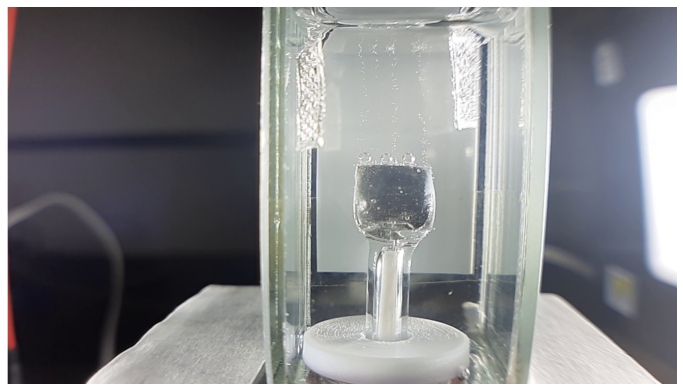

In [2]:
full_video = imageio.imread('../images/full_video.png')
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(full_video)

# Pipeline 

1. Pre-processing: Extracting the area of interest.


2. Tiny Bubbles Analysis.
    
    2.1. Algorithm

        2.1.1. Gray-scale Conversion

        2.1.2. Normalization [0 ... 1]

        2.1.3. Edge Detection: Using canny edge detection algorithm.

        2.1.4. Mathematical Morphology: Closing

        2.1.5. Two-Scan Labeling

        2.1.6. Bubble Selection, Threshold
    
    2.2. Process summary
    
    2.3. Show labeled bubbles with colors
    
    2.4. Complete Algorithm
    
    2.5. Experiments and Results
    
        2.5.1. Executing the algorithm
        
        2.5.2. Output
        
        2.5.3. Processing time
        
        2.5.4. Counting Bubbles 
    
3. Large Bubbles Analysis
    
    3.1. Deep Learning model description
    
    3.2. Tracking big bubbles

# Implementation and Results
## 1. Pre-processing
Extracting the area of interest. The first step of the algorithm consist in delimit the region from where the bubbles start appearing until the top of the glass before where the bubbles disappear. This section of video is stored in a separate mp4 file.

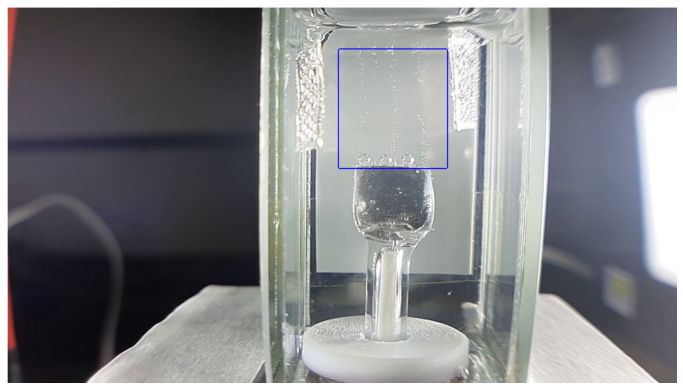

In [3]:
cut_video = imageio.imread('../images/section.png')
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(cut_video)

Here we get a frame of the sectional video.

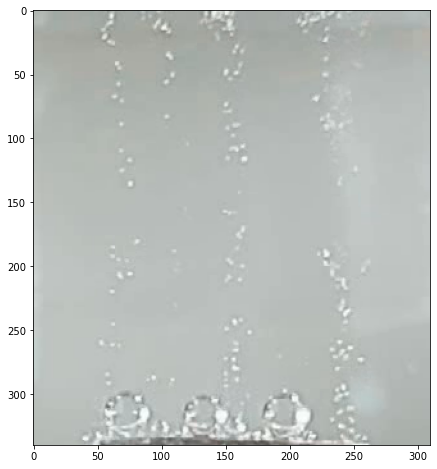

In [4]:
video = cv2.VideoCapture('../videos/Acid_310x340.mp4')
frame = None
for i in range(2500):
    ret, frame = video.read()
plt.figure(figsize=(8,8))
plt.imshow(frame)

## 2. Tiny Bubbles Analysis

The tiny bubbles are continuously moving to the surface unlike the big bubbles that mainly stays in the bottom, this behavior allows us to easily discard the big bubbles from the tiny bubbles analysis. The process consist in apply image processing techniques to enhance the bubbles in contrast of the background and after use a threshold to discard the big bubbles and have only the tiny ones ready for analysis. 

### 2.1. Algorithm
#### 2.1.1. Gray-scale Conversion
Converting the image into gray-scale is the firststep in order to work in only one channel, this will be done by calculating the mean value of the RGB channels, the obtained value is the intensity of the gray-scale pixel.

In [5]:
# 2.1.1. Convert to grayscale
frame_gray = frame.mean(axis = 2)

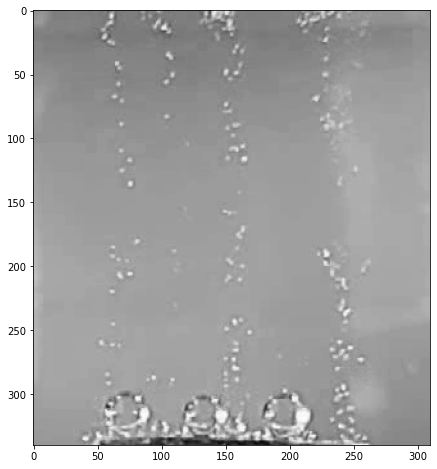

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(frame_gray, cmap = 'gray')

#### 2.1.2. Normalization
The normalization is necessary to standardize the image between the values of 0 and 1, in this case the *img_to_float*[2] function gives us this result.

In [7]:
# 2.1.2. Set the intensities between 0 and 1
frame_float = img_as_float(frame_gray.astype(np.uint8))

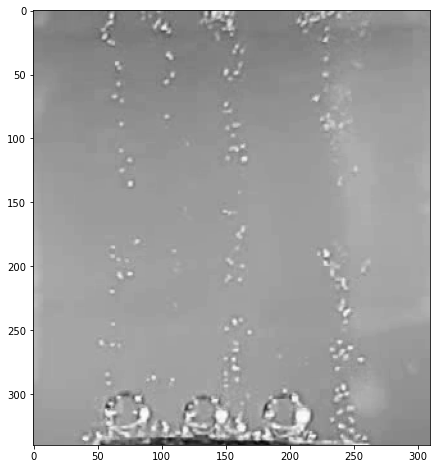

In [8]:
plt.figure(figsize=(8,8))
plt.imshow(frame_float, cmap = 'gray')

#### 2.1.3. Edge Detection
The Canny algorithm can be used to find the edges in an image, the algorithm get this result by using the first derivative of a Gaussian function and after calculating the average magnitude and the density of the edge length the algorithm perform a threshold to get an accurate result. In this process the canny edge detection algorithm is used to find the edges of all the bubbles, we use an explicit threshold value of 0.8 for the algorithm, we use the function *feature.canny*[2] to compute this part of the process.

In [9]:
# 2.1.3. Get the edges using canny, sigma = 0.8
frame_edges = feature.canny(frame_float, sigma = 0.8)
frame_edges = img_as_float(frame_edges)

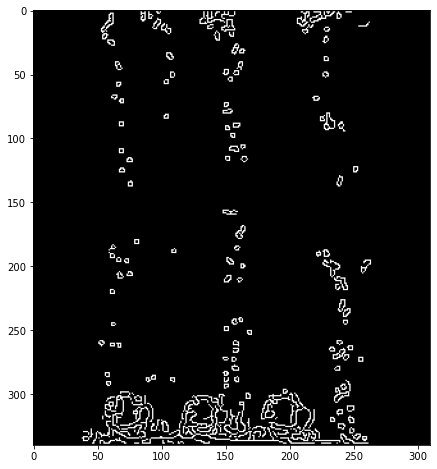

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(frame_edges, cmap = 'gray')

#### 2.1.4. Mathematical Morphology
After the edge detection we have the bubbles surrounded  by  lines,  so  the  next  step  is  apply  mathematical  morphology,  we use a rectangle structuring element of size 3x4 and perform the operations of dilation and erosion, these operations together are called “Closing” (we use the *scikit-image*[2]  implementation).  After  this  step  we  have  our  bubbles  all  marked separate from the noise and the background.

In [11]:
# 2.1.4. Closing the edges (morphological operation, first make dilation, second erosion) with a 3,4 kernel
kernel = np.ones((3,4),np.uint8)
frame_closing = morphology.closing(frame_edges, kernel)

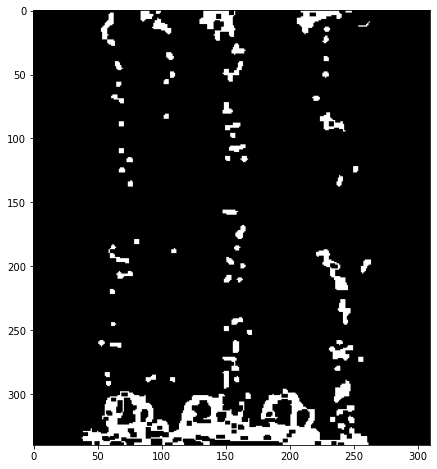

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(frame_closing, cmap = 'gray')

#### 2.1.5. Two-Scan Labeling
The labeling process consist in mark each separated object with a different value or label, He et. al.[3] propose an algorithm to get this goal in two steps, first the algorithm iterate over the whole image marking possible groups of pixels connected, this step produce a data structure with the values needed to set a unique label for each group in the list of separated objects. Once  we have the  bubbles marked in  a binary image  separating  the back-ground and the bubbles, the next step is to separate the bubbles labeling each one with a different label, to get this result we use the algorithm proposed in [3] that can perform this task in a linear time which is a good option due to we are going to perform the task for the entire video with 18809 frames.

In [13]:
Vo = 1000
Vb = 1001

def first_scan(img):
    '''
    rl_table: representative label table
    n_label : next equivalent label 
    t_label : last (tail) equivalent label
    '''
    b = img.copy().astype(np.int)
    b = np.pad(b,((1,1),(1,1)),'constant',constant_values=(Vb))
    b[b==0] = Vb
    b[b==1] = Vo
    X,Y = b.shape
    m = 1
    rl_table = {}
    n_label = {}
    t_label = {}
    for x in range(1,X-1):
        for y in range(1,Y-1):
            if b[x,y] != Vb:
                mask = [b[x-1,y-1],b[x-1,y],b[x-1,y+1],b[x,y-1]]
                
                b_min = min(mask)
                if b_min == Vb:
                    b[x,y] = m
                    rl_table[m] = m
                    n_label[m] = -1
                    t_label[m] = m
                    m += 1
                else:
                    j = b_min
                    b[x,y] = j
                    for k in mask:
                        if k < Vo:
                            if rl_table[j] != rl_table[k]:
                                if rl_table[j] < rl_table[k]:
                                    u = rl_table[j]
                                    v = rl_table[k]
                                else:
                                    v = rl_table[j]
                                    u = rl_table[k]
                                i = v
                                while(i > -1):
                                    rl_table[i] = u
                                    i = n_label[i]
                                n_label[t_label[u]] = v
                                t_label[u] = t_label[v]
    return (img, b[1:-1,1:-1], rl_table, n_label, t_label)

def second_scan(b, rlt):
    '''
    b: output b from first scan
    rlt: representative label table
    '''
    for r in rlt:
        b[b==r] = rlt[r]
    b[b==Vb] = 0
    return b

def two_scan_labeling(img):
    '''
    img: binary image (0,1) (0: background)
    '''
    img, b, rl_table, _, _ = first_scan(img)
    res = second_scan(b, rl_table)
    return res

In [14]:
# 2.1.5. Labeling
frame_labeled = two_scan_labeling(frame_closing)

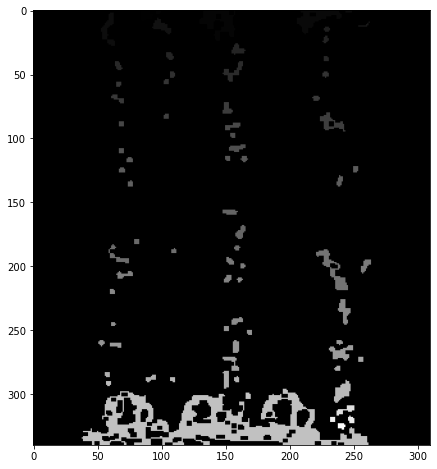

In [15]:
plt.figure(figsize=(8,8))
plt.imshow(frame_labeled, cmap = 'gray')

#### 2.1.6.  Bubble Selection, Threshold
With  the  labels  separated,  we  can  notice  apart  of  the  tiny bubbles, we have some objects labeled that are not of our interest, these are the big bubbles and the small portion of the electrode in the bottom of the image, we can solve this by using a quantity of pixels threshold in the labels, so we only take in count the small labels.

In [16]:
# 2.1.6. Remove big labels (more than 500 pixels)
frame_labeled_th = frame_labeled.copy()
labels = np.unique(frame_labeled)
for l in labels[1:]:
    s = frame_labeled[frame_labeled == l].shape[0]
    if s > 500:
        frame_labeled_th[frame_labeled == l] = 0

In [17]:
# Making the labels more intense to make them visible
frame_labeled = 255 - frame_labeled
frame_labeled[frame_labeled == 255] = 0
frame_labeled_th = 255 - frame_labeled_th
frame_labeled_th[frame_labeled_th == 255] = 0

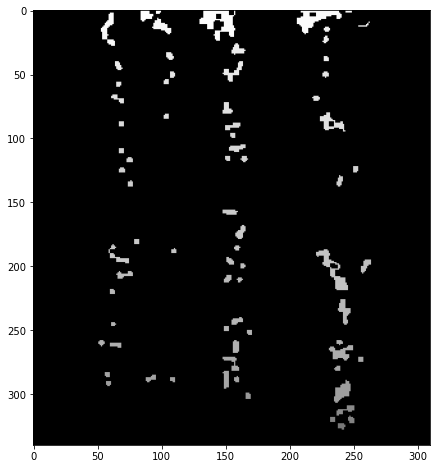

In [18]:
plt.figure(figsize=(8,8))
plt.imshow(frame_labeled_th, cmap = 'gray')

### 2.2. Process summary

Next we can see all the transformations that the frame has had

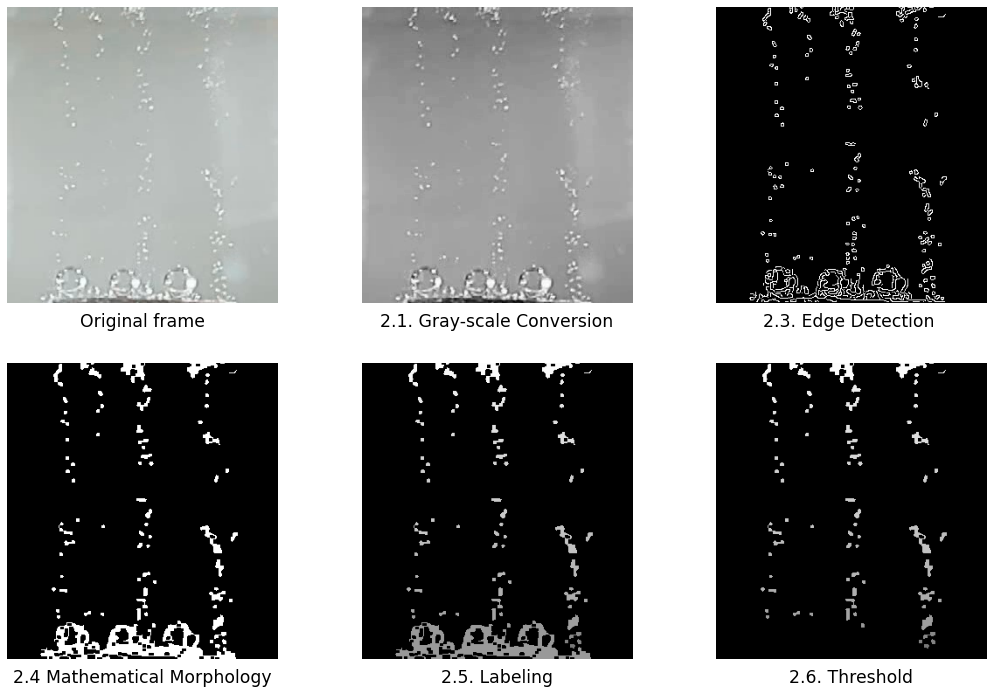

In [19]:
plt.figure(figsize=(18,12))
plt.subplot(2,3,1)
plt.axis('off')
plt.title('Original frame', y=-0.1, fontsize = 'xx-large')
plt.imshow(frame)
plt.subplot(2,3,2)
plt.axis('off')
plt.title('2.1.1. Gray-scale Conversion', y=-0.1, fontsize = 'xx-large')
plt.imshow(frame_gray, cmap = 'gray')
plt.subplot(2,3,3)
plt.axis('off')
plt.title('2.1.3. Edge Detection ', y=-0.1, fontsize = 'xx-large')
plt.imshow(frame_edges, cmap = 'gray')
plt.subplot(2,3,4)
plt.axis('off')
plt.title('2.1.4 Mathematical Morphology', y=-0.1, fontsize = 'xx-large')
plt.imshow(frame_closing, cmap = 'gray')
plt.subplot(2,3,5)
plt.axis('off')
plt.title('2.1.5. Labeling', y=-0.1, fontsize = 'xx-large')
plt.imshow(frame_labeled, cmap = 'gray', vmin = 0, vmax = 255)
plt.subplot(2,3,6)
plt.axis('off')
plt.title('2.1.6. Threshold', y=-0.1, fontsize = 'xx-large')
plt.imshow(frame_labeled_th, cmap = 'gray', vmin = 0, vmax = 255)

### 2.3. Show labeled bubbles with colors

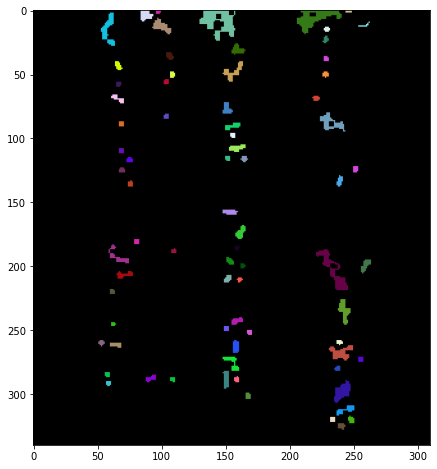

In [20]:
def color_labels(labels):
    colored_labels = np.zeros((labels.shape[0], labels.shape[1], 3)).astype(np.uint8)
    all_labels = np.unique(labels)
    all_labels = all_labels[all_labels != 0]

    for l in all_labels:
        r = int(np.random.rand()*256)
        g = int(np.random.rand()*256)
        b = int(np.random.rand()*256)
        colored_labels[labels == l] = np.array([r,g,b])
    return colored_labels

colored_labels = color_labels(frame_labeled_th)

plt.figure(figsize=(8,8))
plt.imshow(colored_labels)

### 2.4. Complete Algorithm

In [21]:
def label_bubbles(image):
    image_gray = image.mean(axis = 2)
    image_float = img_as_float(image_gray.astype(np.uint8))
    image_edges = feature.canny(image_float, sigma = 0.8)
    image_edges = img_as_float(image_edges)
    kernel = np.ones((3,4),np.uint8)
    image_closing = morphology.closing(image_edges, kernel)
    image_labeled = two_scan_labeling(image_closing)
    image_labeled_th = image_labeled.copy()
    labels = np.unique(image_labeled)
    for l in labels[1:]:
        s = image_labeled[image_labeled == l].shape[0]
        if s > 500:
            image_labeled_th[image_labeled == l] = 0
    return image_labeled_th

### 2.5. Experiments and Results

We are performing simple experiments to show the behavior of the algorithm, we are going to use 10 consecutive frames of the bubbles video

In [22]:
video = cv2.VideoCapture('../videos/Acid_310x340.mp4')
frames = []
for i in range(2500):
    video.read()
for i in range(10):
    ret, frame = video.read()
    frames.append(frame)

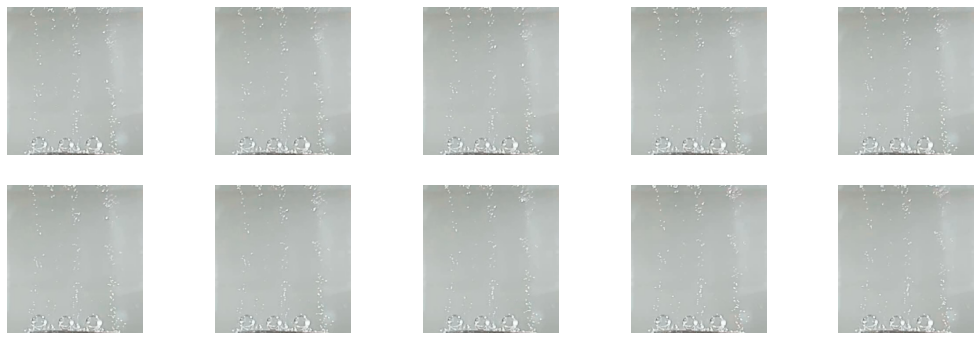

In [23]:
plt.figure(figsize=(18,6))
for i, frame in enumerate(frames):
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.imshow(frame)

#### 2.5.1. Executing the algorithm

We execute the algorithm in the 10 extracted frames, getting the outputs, execution time, and counting the bubbles

In [24]:
import time
times = []
outs = []
for frame in frames:
    t1 = time.time() * 1000
    out = label_bubbles(frame)
    t2 = time.time() * 1000
    outs.append(out)
    times.append(t2-t1)

#### 2.5.2. Output

Obtained output after applying our algorithm

In [25]:
colored_outs = []
for out in outs:
    col_out = color_labels(out)
    colored_outs.append(col_out)

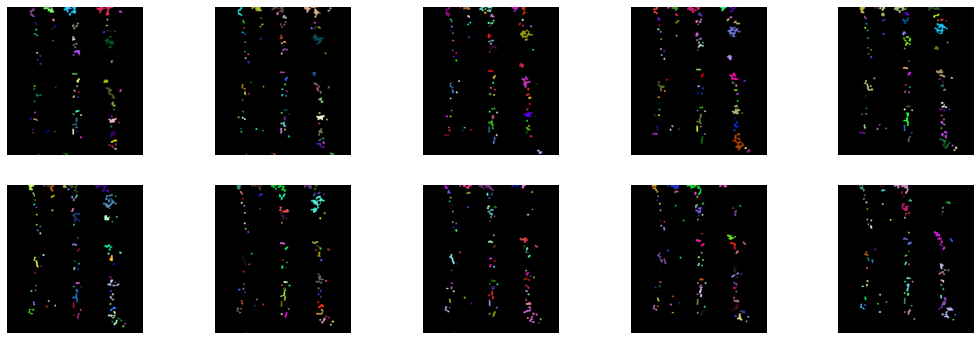

In [26]:
plt.figure(figsize=(18,6))
for i, col_out in enumerate(colored_outs):
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.imshow(col_out)

#### 2.5.3. Processing time

The processing time is important because this algorithm is going to be applied in a video with 18809 frames

In [27]:
print('Mean of processing times: %.3f milliseconds' % np.mean(times))
print('Estimated total video processing time: %.3f minutes ' % (((np.mean(times)*18809) / 1000)/60))

Mean of processing times: 192.831 milliseconds
Estimated total video processing time: 60.449 minutes 


#### 2.5.4. Counting Bubbles

The quantity of bubbles is one of the data of interest in this project, so we left a basic approach counting the bubbles frame by frame, multiple advanced algorithms could be used in order to obtain relevant information for the experiment

In [28]:
for i, out in enumerate(outs):
    print('Frame %.1d: %.1d bubbles' % (i+1,np.unique(out).shape[0] - 1 ))

Frame 1: 77 bubbles
Frame 2: 76 bubbles
Frame 3: 77 bubbles
Frame 4: 73 bubbles
Frame 5: 73 bubbles
Frame 6: 75 bubbles
Frame 7: 74 bubbles
Frame 8: 78 bubbles
Frame 9: 76 bubbles
Frame 10: 71 bubbles


## 3. Large Bubbles Analysis

*In this part we only show the results of the experiment due to the high load processes of deep learning and the large amount of data generated.*

The big bubbles are mainly present in the bottom of the image, close to the electrode, until they disconnect from the electrode and goes to the surface, in this case we consider the tiny bubbles as part of the background, this could difficult the image analysis due to the similarity of the intensity of pixels, however a deep learning technique should be capable of detect the difference between big and tiny bubbles.

### 3.1. Deep Learning model description

Transfer learning is used in the pre-trained model ResNet-50 adding a new conv5_x layer, the pre-trained model and this new empty layer are trained with a data-set of 100 images with the big bubbles labeled as shown in Figure (a), this model was trained with the following hyperparameters: learning rate: 0.005, momentum: 0.9, weight decay: 0.0005, epochs: 100.
Figure (b) shows one frame with the predicted big bubbles contained, a threshold in the accurate of the predictions has been used in order to only get the bubbles with more than 90% of accurate.



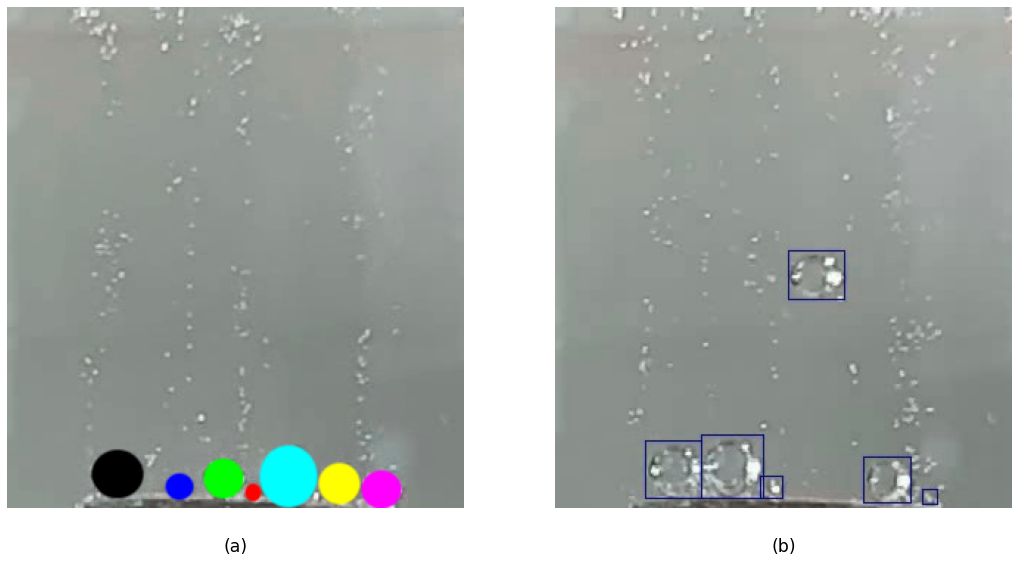

In [3]:
img_big_train = cv2.imread('../images/frame_6883.png')
img_big_test = cv2.imread('../images/frame_big_pred.jpeg')

plt.figure(figsize=(18,12))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('(a)', y=-0.1, fontsize = 'xx-large')
plt.imshow(img_big_train)
plt.subplot(1,2,2)
plt.axis('off')
plt.title('(b)', y=-0.1, fontsize = 'xx-large')
plt.imshow(img_big_test, cmap = 'gray')

### 3.2. Tracking big bubbles

The algorithm use to track the bubbles from one frame to the next one is based on calculating center of the predicted bounding box, we start by choosing a predicted bounding box from one frame and calculate its center, using the euclidean distance we compare the center with all centers of bubbles from the next frame and we assume that the closest one is the same bubble from the previous frame. This behavior is continuous until the bubble is disconnected from the electrode, when that happens the bubbles tends to go up to the surface and once it is in the surface go to the right or left of the top of the glass until disappears, to track the bubble in these cases we compare the centers as before but taking in count only the y axis and for the x axis we just check if it is going up.

In [4]:
# Loading one bubble tacked sample
import json
f = open('../data/10.json')
lines = f.readlines()
len(lines)

4525

- Loading 5 sample frames resulting of the tracking algorithm

In [6]:
n = 5
js = []
for i in range(n):
    j = json.loads(lines[4515 + i])
    js.append(j)
#j = json.loads(lines[4516])
    print(j)

{'id': 5053, 'boxes': [[165.1059112548828, 274.57830810546875, 220.302001953125, 329.69677734375]], 'scores': [0.9968796968460083]}
{'id': 5054, 'boxes': [[165.3911895751953, 225.97999572753906, 218.8443145751953, 272.4441223144531]], 'scores': [0.9951044321060181]}
{'id': 5055, 'boxes': [[164.3808135986328, 152.60983276367188, 220.01467895507812, 195.41062927246094]], 'scores': [0.9964181184768677]}
{'id': 5056, 'boxes': [[166.70652770996094, 72.49195861816406, 223.63397216796875, 119.09742736816406]], 'scores': [0.9937173128128052]}
{'id': 5057, 'boxes': [[179.8533172607422, 0.0, 235.9788818359375, 41.61481857299805]], 'scores': [0.9696319699287415]}


- Showing the sample frames with the predicted big bubble tracked frame by frame

In [7]:
video2 = cv2.VideoCapture('../videos/Acid_310x340.mp4')
frame2 = None
for i in range(5052):
    ret, frame2 = video2.read()
frames = []
for i in range(n):
    ret, frame2 = video2.read()
    frames.append(frame2)

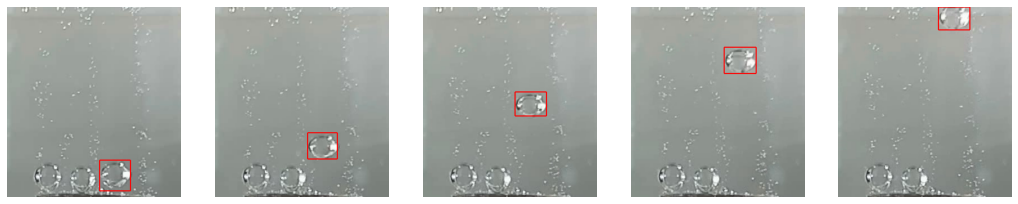

In [8]:
plt.figure(figsize=(18,18))
for i in range(n):
    frame3 = frames[i].copy()
    j = js[i]
    x1 = int(j['boxes'][0][1])
    y1 = int(j['boxes'][0][0])
    x2 = int(j['boxes'][0][3])
    y2 = int(j['boxes'][0][2])

    pad = 1
    
    frame3[x1,y1:y2] = np.array([255,0,0])
    if i != n - 1:
        frame3[x1-1,y1:y2] = np.array([255,0,0])
    frame3[x2,y1:y2] = np.array([255,0,0])
    frame3[x2-1,y1:y2] = np.array([255,0,0])
    frame3[x1:x2,y1] = np.array([255,0,0])
    frame3[x1:x2,y1-1] = np.array([255,0,0])
    frame3[x1:x2,y2] = np.array([255,0,0])
    frame3[x1:x2,y2-1] = np.array([255,0,0])
    plt.subplot(1,5,i + 1)
    plt.axis('off')
    plt.imshow(frame3)

We can see how the box behaves properly, following the path of the same bubble.

# Discussion of results
## Tiny Bubbles 
The result of the tiny bubbles analysis is a new data-set conformed by the same quantity of frames from the original video, but containing only the tiny images labeled, this labeled bubbles are harder to track from frame to frame because of their size and their movement in the video.

It was possible to label the bubbles and show a visualization by colors, seeing that most of them are separate.

The analysis of the entire video takes 60,449 minutes, which is still tolerable considering that it has 18,809 frames and a duration of 10 minutes and 27 seconds.

It was also possible to count the number of bubbles that ranges from 71 to 78 in 10 frames, this because several of them disappear, become divided, new ones arise.

## Large Bubbles 
The result of the big bubbles analysis is a new data-set conformed by 23617 possible bubbles tracked, each item of this data-set contains the area and position of the bubble and the path that follows through the video frame by frame.

The path of the bubbles could be marked with a box, this is verified in the course of the frames.

##  Future Work
In both cases we obtain a data-set ready to perform analysis tasks to get relevant information about the electrolysis process, several statistic and image processing algorithms can be used in these data-sets to obtain new data such as the velocity or quantity of the bubbles.
The use of this results can lead into an analysis of the efficiency of different experiments of electrolysis of water, and performing the proposed analysis is possible to gain information about the effectiveness of the process until get a viable way to obtain enough energy to apply the electrolysis as main source of energy of some electronic equipment.
Some of the possible analysis that can be made in the obtained data-sets are distance transformation, area measurement, velocity measurement and image registration.

# Participation of the members

## Alexis J. Vargas

He was in charge of:
- Gathering information.
- Collect the input data (video).
- Investigation of techniques for the treatment of images.
- Labeling of input data for large bubble processing.
- Implementation of the techniques.
- Testing.

## Karelia A. Vilca 

She was in charge of:
- Synthesize the data.
- Investigation of techniques for the treatment of images.
- Improving the implementation of techniques.
- Monitoring of large bubble treatment.
- Testing.
- Document and organize information.

**References**

[1] OpenCV, https://opencv.org/

[2] scikit-image: Image processing in Python — scikit-image, https://scikit-image.org/

[3] He, L., Chao, Y., Suzuki, K.: A linear-time two-scan labeling algorithm. In: 2007
IEEE International Conference on Image Processing. vol. 5, pp. V – 241–V – 244
(Sep 2007). https://doi.org/10.1109/ICIP.2007.4379810